# **Monte Carlo Variance Reduction Methods – Antithetic**

We can reduce the variance of the results of the Monte Carlo simulation method when valuing financial derivatives. Unfortunately, while this is a great method for approximating option values ​​with complex payouts or high dimensionality,  to get a sufficiently accurate estimate we need to do a large number of M simulations. We can instead rely on  methods of reducing variance that work on the same principles as hedging for an options position. that is, the variability of a hedged options portfolio will have a lower variance than the variance of an unhedged options portfolio.

In [17]:
# Import dependencies
import math
import numpy as np
import pandas as pd
import datetime
import time
import scipy.stats as stats
import matplotlib.pyplot as plt
from py_vollib.black_scholes.implied_volatility import implied_volatility as iv
from py_vollib.black_scholes import black_scholes as bs
from py_vollib.black_scholes.greeks.analytical import vega, delta

# **Antithetic Variates**

Let’s write an option on asset S1  and another option on asset S2  that is perfectly negatively correlated with S1  and which currently has the same price. S1  and S2  satisfy the following Stochastic Differential Equations:

dS1,t=rdS1,tdt+σdS1,tdzt

dS2,t=rdS2,tdt−σdS2,tdzt

Since the price and volatility of the two assets are identical, so is the value of the two options. However, the variance of the returns of the portfolio containing these two contracts is much lower than the variance of the returns of the individual contracts. We essentially remove the large peak from the probability distribution of a contract payout. i.e. basic intuition: when one option succeeds, the other does not.

# **Implementation of Antithetic Variate**

To implement an antithetic variate we create a hypothetical asset which is perfectly negatively correlated with the original asset. Implementation is very simple, and if we consider the example of the European Call Option, our simulated pay-offs are under the following St dynamics:

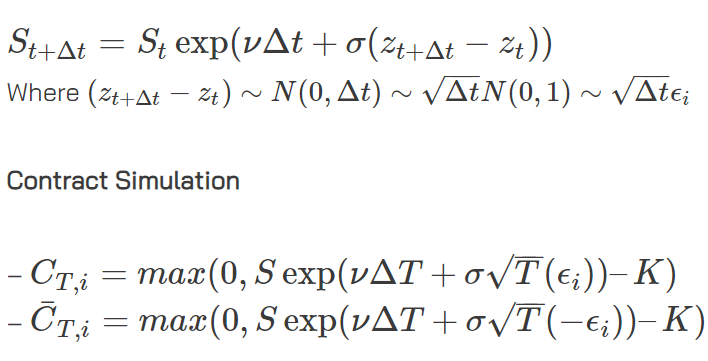

In [2]:
# initial derivative parameters 
S = 101.15          #stock price
K = 98.01           #strike price
vol = 0.0991        #volatility (%)
r = 0.015            #risk-free rate (%)
N = 10              #number of time steps
M = 1000            #number of simulations
market_value = 3.86 #market price of option
T = ((datetime.date(2022,3,17)-datetime.date(2022,1,17)).days+1)/365    #time in years
print(T)

0.1643835616438356


# **Slow Solution – Steps**

We break it down into slow discretized steps, although for the purposes of a European Call Option we do not have to take steps as the discretization perfectly represents the SDE.

In [3]:
# Precompute constants
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S)
# Standard Error Placeholders
sum_CT = 0
sum_CT2 = 0
# Monte Carlo Method
for i in range(M):
    lnSt1 = lnS
    lnSt2 = lnS
    for j in range(N):
        # Perfectly Negatively Correlated Assets
        epsilon = np.random.normal()
        lnSt1 = lnSt1 + nudt + volsdt*epsilon
        lnSt2 = lnSt2 + nudt - volsdt*epsilon
    
    ST1 = np.exp(lnSt1)
    ST2 = np.exp(lnSt2)
    CT = 0.5 * ( max(0, ST1 - K) + max(0, ST2 - K) )
    sum_CT = sum_CT + CT
    sum_CT2 = sum_CT2 + CT*CT
# Compute Expectation and SE
C0 = np.exp(-r*T)*sum_CT/M
sigma = np.sqrt( (sum_CT2 - sum_CT*sum_CT/M)*np.exp(-2*r*T) / (M-1) )
SE = sigma/np.sqrt(M)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))

Call value is $3.81 with SE +/- 0.03


# **Fast Solution – Vectorized**

For simple processes where the SDE does not need to be approximated, as in the case of the geometric Brownian motion used to calculate the European option price, we can simply simulate the variables at the last time step. the same time as the Brownian motion develops in time and in independent increments.

In [4]:
#precompute constants
N = 1
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S)
# Monte Carlo Method
Z = np.random.normal(size=(N, M)) 
delta_lnSt1 = nudt + volsdt*Z 
delta_lnSt2 = nudt - volsdt*Z 
lnSt1 = lnS + np.cumsum(delta_lnSt1, axis=0)
lnSt2 = lnS + np.cumsum(delta_lnSt2, axis=0)
# Compute Expectation and SE
ST1 = np.exp(lnSt1)
ST2 = np.exp(lnSt2)
CT = 0.5 * ( np.maximum(0, ST1[-1] - K) + np.maximum(0, ST2[-1] - K) )
C0 = np.exp(-r*T)*np.sum(CT)/M
sigma = np.sqrt( np.sum( (CT - C0)**2) / (M-1) )
SE = sigma/np.sqrt(M)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))

Call value is $3.83 with SE +/- 0.03


# **Compare without Antithetic Variate**

In [5]:
#precompute constants
N = 1
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S)
# Monte Carlo Method
Z = np.random.normal(size=(N, M)) 
delta_lnSt = nudt + volsdt*Z 
lnSt = lnS + np.cumsum(delta_lnSt, axis=0)
lnSt = np.concatenate( (np.full(shape=(1, M), fill_value=lnS), lnSt ) )
# Compute Expectation and SE
ST = np.exp(lnSt)
CT = np.maximum(0, ST - K)
C0w = np.exp(-r*T)*np.sum(CT[-1])/M
sigma = np.sqrt( np.sum( (CT[-1] - C0)**2) / (M-1) )
SEw = sigma/np.sqrt(M)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))

Call value is $3.83 with SE +/- 0.03


# **Visualisation of Convergence**

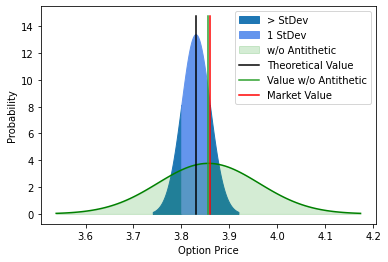

In [6]:
x1 = np.linspace(C0-3*SE, C0-1*SE, 100)
x2 = np.linspace(C0-1*SE, C0+1*SE, 100)
x3 = np.linspace(C0+1*SE, C0+3*SE, 100)
xw = np.linspace(C0w-3*SEw, C0w+3*SEw, 100)
s1 = stats.norm.pdf(x1, C0, SE)
s2 = stats.norm.pdf(x2, C0, SE)
s3 = stats.norm.pdf(x3, C0, SE)
sw = stats.norm.pdf(xw, C0w, SEw)
plt.fill_between(x1, s1, color='tab:blue',label='> StDev')
plt.fill_between(x2, s2, color='cornflowerblue',label='1 StDev')
plt.fill_between(x3, s3, color='tab:blue')
plt.plot(xw, sw, 'g-')
plt.fill_between(xw, sw, alpha=0.2, color='tab:green', label='w/o Antithetic')
plt.plot([C0,C0],[0, max(s2)*1.1], 'k',
        label='Theoretical Value')
plt.plot([C0w,C0w],[0, max(s2)*1.1], color='tab:green',
        label='Value w/o Antithetic')
plt.plot([market_value,market_value],[0, max(s2)*1.1], 'r',
        label='Market Value')
plt.ylabel("Probability")
plt.xlabel("Option Price")
plt.legend()
plt.show()

# **Benefits of Antithetic Variance Reduction**

By using (ϵi,−ϵi) pairs in the simulation, we can now get a more accurate estimate from M pairs (CT,i,C¯T,i) than from 2M CT,i . Computationally, generating the pair (CT,i,C¯T,i) is also less expensive than the two cases CT,i. This method also ensures that the mean of the samples with a normal distribution is exactly zero, which improves the simulation.


# **Control Variates & Hedging**

The probability distribution of an option payout after delta hedging has a smaller standard deviation than the unhedged counterpart in its portfolio. Consider the dynamics of a discretely rebalanced delta hedge:

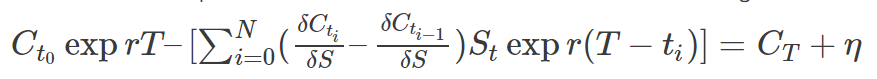

The first term is the forward value of the premium recieved for writing the option, the second term represents the cash flows from rebalancing the headge at each time t, and the third term is the pay-off of the option and the hedging error η .

Now if we expand the terms in the square brackets:

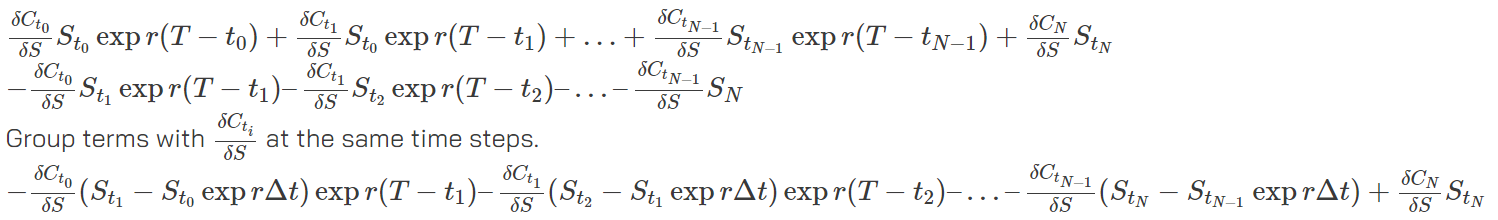

If we assume that the final term is zero, it is equivalent to not buying the final delta amount of the asset, but simplifies the liquidation of the underlying holdings from the previous rebalancing date by cash, the portfolio becomes:

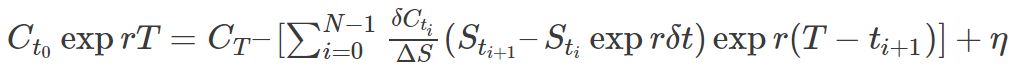

The term in the square brackets (the delta hedge) is a delta-based martingale control variate (cv1 ). This can be written as:

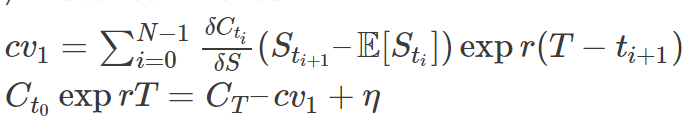

# **Gamma Based Control Variate**

The control variate is a random variable whose expected value we know, which is correlated with the varaible we are trying to estimate.
In the same way as for cv1  we can create other control variates, which are equivalent to other hedges. 
For example a gamma-based control variate (cv2):

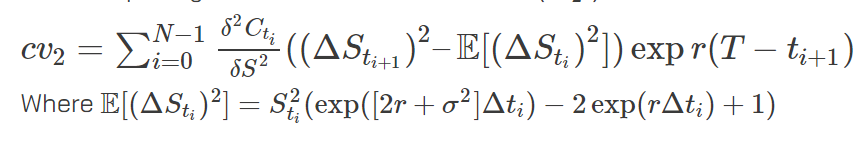

# **General Control Variate Equation**

For J control variates we have:

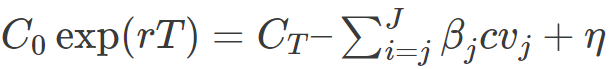


The option price is the sum of the linear relations with the control variables J CT=β0+∑Ji=jβjcvj+η where β0=C0exp(rT) is the option futures price.

If we perform M simulations at discrete time intervals N separately, we can consider the returns and control variates as samples of a linear relationship with some noise. We can estimate the true relationship between the control variates and the option rate of return using least squares regression: β=(X′X)−1X′Y. We don't want the estimates βj to be biased so they must be precomputed by least squares regression first establishing the relationship between the types of control variates and the options. These βj value estimates can then be used for cvj to evaluate any option.

# **Implementation of Delta-based Control Variates**

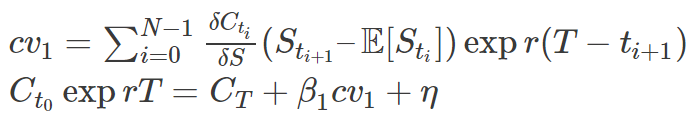

where with GBM dynamics: 

– E[Sti]=Sti−1exp(rΔti)

– β1=−1  which is the appropriate value where we have exact delta for European Option

In [9]:
# initial derivative parameters 
S = 101.15          #stock price
K = 98.01           #strike price
vol = 0.0991        #volatility (%)
r = 0.015            #risk-free rate (%)
N = 10              #number of time steps
M = 1000            #number of simulations
market_value = 3.86 #market price of option
T = ((datetime.date(2022,3,17)-datetime.date(2022,1,17)).days+1)/365    #time in years
print(T)

0.1643835616438356


# **Slow Solution – Steps**

Here we simulate stock price St directly because we require this value during the calculation to determine the delta.

In [10]:
# Precompute constants
N = 10
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
erdt = np.exp(r*dt)
beta1 = -1
# Standard Error Placeholders
sum_CT = 0
sum_CT2 = 0
# Monte Carlo Method
for i in range(M):
    St = S 
    cv = 0
    for j in range(N):
        epsilon = np.random.normal()
        deltaSt = delta('c', St, K, T-j*dt, r, vol)
        Stn = St*np.exp( nudt + volsdt*epsilon )
        cv = cv + deltaSt*(Stn - St*erdt)
        St = Stn
    CT = max(0, St - K) + beta1*cv
    sum_CT = sum_CT + CT
    sum_CT2 = sum_CT2 + CT*CT
# Compute Expectation and SE
C0 = np.exp(-r*T)*sum_CT/M
sigma = np.sqrt( (sum_CT2 - sum_CT*sum_CT/M)*np.exp(-2*r*T) / (M-1) )
SE = sigma/np.sqrt(M)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,3)))

Call value is $3.83 with SE +/- 0.011


# **Fast Solution – Vectorized**

In [11]:
def delta_calc(r, S, K, T, sigma, type="c"):
    "Calculate delta of an option"
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
    try:
        if type == "c":
            delta_calc = stats.norm.cdf(d1, 0, 1)
        elif type == "p":
            delta_calc = -stats.norm.cdf(-d1, 0, 1)
        return delta_calc
    except:
        print("Please confirm option type, either 'c' for Call or 'p' for Put!")

In [12]:
#precompute constants
N = 1
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
erdt = np.exp(r*dt)
cv = 0
beta1 = -1
# Monte Carlo Method
Z = np.random.normal(size=(N, M)) 
delta_St = nudt + volsdt*Z
ST = S*np.cumprod( np.exp(delta_St), axis=0)
ST = np.concatenate( (np.full(shape=(1, M), fill_value=S), ST ) )
deltaSt = delta_calc(r, ST[:-1].T, K, np.linspace(T,0,N), vol, "c").T
cv = np.cumsum(deltaSt*(ST[1:] - ST[:-1]*erdt), axis=0)
CT = np.maximum(0, ST[-1] - K) + beta1*cv[-1]
# CT = np.maximum(0, ST[-1] - K)
C0 = np.exp(-r*T)*np.sum(CT)/M
sigma = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0)**2) / (M-1) )
sigma = np.std(np.exp(-r*T)*CT)
SE = sigma/np.sqrt(M)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,3)))

Call value is $3.86 with SE +/- 0.031


# **Compare without Delta-based Control Variate**

In [13]:
#precompute constants
N = 1
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
# Monte Carlo Method
Z = np.random.normal(size=(N, M)) 
delta_St = nudt + volsdt*Z
ST = S*np.cumprod( np.exp(delta_St), axis=0)
CTw = np.maximum(0, ST[-1] - K)
C0w = np.exp(-r*T)*np.sum(CTw)/M
sigma = np.sqrt( np.sum( (np.exp(-r*T)*CTw - C0w)**2) / (M-1) )
SEw = sigma/np.sqrt(M)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0w,2),np.round(SEw,3)))

Call value is $3.93 with SE +/- 0.108


# **Visualisation of Convergence**

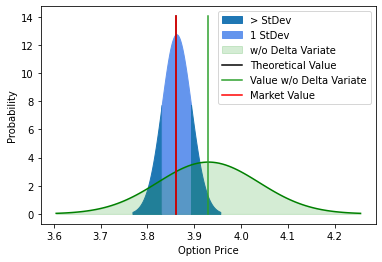

In [14]:
x1 = np.linspace(C0-3*SE, C0-1*SE, 100)
x2 = np.linspace(C0-1*SE, C0+1*SE, 100)
x3 = np.linspace(C0+1*SE, C0+3*SE, 100)
xw = np.linspace(C0w-3*SEw, C0w+3*SEw, 100)

s1 = stats.norm.pdf(x1, C0, SE)
s2 = stats.norm.pdf(x2, C0, SE)
s3 = stats.norm.pdf(x3, C0, SE)
sw = stats.norm.pdf(xw, C0w, SEw)

plt.fill_between(x1, s1, color='tab:blue',label='> StDev')
plt.fill_between(x2, s2, color='cornflowerblue',label='1 StDev')
plt.fill_between(x3, s3, color='tab:blue')
plt.plot(xw, sw, 'g-')
plt.fill_between(xw, sw, alpha=0.2, color='tab:green', label='w/o Delta Variate')

plt.plot([C0,C0],[0, max(s2)*1.1], 'k',
        label='Theoretical Value')
plt.plot([C0w,C0w],[0, max(s2)*1.1], color='tab:green',
        label='Value w/o Delta Variate')
plt.plot([market_value,market_value],[0, max(s2)*1.1], 'r',
        label='Market Value')

plt.ylabel("Probability")
plt.xlabel("Option Price")
plt.legend()
plt.show()

# **Gamma Based Control Variate**

The control variate is a random variable whose expected value we know, which is correlated with the varaible we are trying to estimate.
In the same way as for cv1 we can create other control variates, which are equivalent to other hedges. 
For example a gamma-based control variate (cv2):

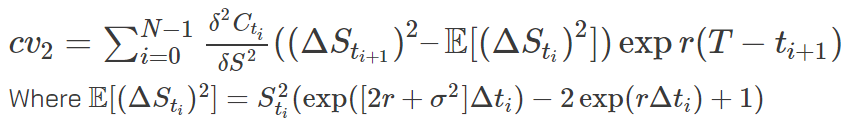

In [15]:
def gamma_calc(r, S, K, T, sigma):
    "Calculate delta of an option"
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
    try:
        gamma_calc = stats.norm.pdf(d1, 0, 1)/(S*sigma*np.sqrt(T))
        return gamma_calc
    except:
        print("Please confirm option type, either 'c' for Call or 'p' for Put!")

In [18]:
start_time = time.time()
#precompute constants
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
erdt = np.exp(r*dt)
ergamma = np.exp((2*r+vol**2)*dt) - 2*erdt + 1
beta2 = -0.5
# Monte Carlo Method
Z = np.random.normal(size=(N, M)) 
delta_St = nudt + volsdt*Z
ST = S*np.cumprod( np.exp(delta_St), axis=0)
ST = np.concatenate( (np.full(shape=(1, M), fill_value=S), ST ) )
gammaSt = gamma_calc(r, ST[:-1].T, K, np.linspace(T,dt,N), vol).T
cv2 = np.cumsum(gammaSt*((ST[1:] - ST[:-1])**2 - ergamma*ST[:-1]**2), axis=0)
CT = np.maximum(0, ST[-1] - K) + beta2*cv2[-1]
C0_gv = np.exp(-r*T)*np.sum(CT)/M
sigma = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0_gv)**2) / (M-1) )
sigma = np.std(np.exp(-r*T)*CT)
SE_gv = sigma/np.sqrt(M)
mc_time_gv = time.time() - start_time
print("Call value is ${0} with SE +/- {1}".format(np.round(C0_gv,2),np.round(SE_gv,3)))
print("Computation time is: ", round(mc_time_gv,4))

Call value is $3.88 with SE +/- 0.101
Computation time is:  0.0067


# **Combined Antithetic and Delta Variates**

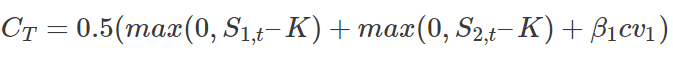

where cv1 is delta variate but now we have to account for antithetic variates – two perfectly negatively correlated underlyings. 

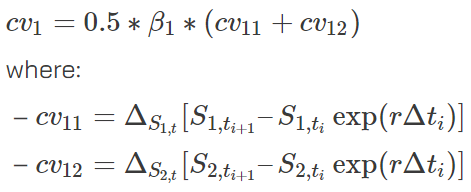

In [19]:
start_time = time.time()

#precompute constants
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
erdt = np.exp(r*dt)
beta1 = -1

# Monte Carlo Method
Z = np.random.normal(size=(N, M)) 
delta_St1 = nudt + volsdt*Z
delta_St2 = nudt - volsdt*Z
ST1 = S*np.cumprod( np.exp(delta_St1), axis=0)
ST2 = S*np.cumprod( np.exp(delta_St2), axis=0)
ST1 = np.concatenate( (np.full(shape=(1, M), fill_value=S), ST1 ) )
ST2 = np.concatenate( (np.full(shape=(1, M), fill_value=S), ST2 ) )

# Calculate delta for both sets of underlying stock prices
deltaSt1 = delta_calc(r, ST1[:-1].T, K, np.linspace(T,dt,N), vol, "c").T
deltaSt2 = delta_calc(r, ST2[:-1].T, K, np.linspace(T,dt,N), vol, "c").T

# Calculate two sets of delta control variates for negatively correlated assets
cv11 = np.cumsum(deltaSt1*(ST1[1:] - ST1[:-1]*erdt), axis=0)
cv12 = np.cumsum(deltaSt2*(ST2[1:] - ST2[:-1]*erdt), axis=0)

CT = 0.5 * (  np.maximum(0, ST1[-1] - K) + beta1*cv11[-1] 
            + np.maximum(0, ST2[-1] - K) + beta1*cv12[-1] )

C0_adv = np.exp(-r*T)*np.sum(CT)/M

sigma = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0_adv)**2) / (M-1) )
sigma = np.std(np.exp(-r*T)*CT)
SE_adv = sigma/np.sqrt(M)

mc_time_adv = time.time() - start_time

print("Call value is ${0} with SE +/- {1}".format(np.round(C0_adv,2),np.round(SE_adv,3)))
print("Computation time is: ", round(mc_time_adv,4))

Call value is $3.82 with SE +/- 0.025
Computation time is:  0.0107


# **Combined Antithetic, Delta and Gamma Variates**

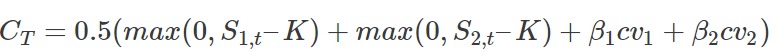

where cv1 is delta variate and cv2 is the gamma variate. When combined with antithetic technique you have to apply the following!

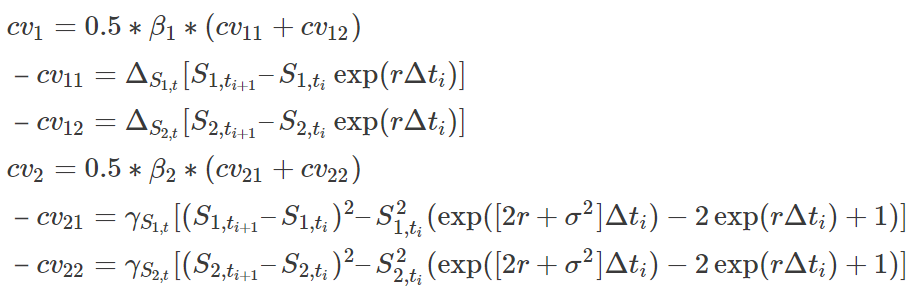

In [20]:
start_time = time.time()

#precompute constants
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
erdt = np.exp(r*dt)
ergamma = np.exp((2*r+vol**2)*dt) - 2*erdt + 1

beta1 = -1
beta2 = -0.5

# Monte Carlo Method
Z = np.random.normal(size=(N, M)) 
delta_St1 = nudt + volsdt*Z
delta_St2 = nudt - volsdt*Z
ST1 = S*np.cumprod( np.exp(delta_St1), axis=0)
ST2 = S*np.cumprod( np.exp(delta_St2), axis=0)
ST1 = np.concatenate( (np.full(shape=(1, M), fill_value=S), ST1 ) )
ST2 = np.concatenate( (np.full(shape=(1, M), fill_value=S), ST2 ) )

# Calculate delta for both sets of underlying stock prices
deltaSt1 = delta_calc(r, ST1[:-1].T, K, np.linspace(T,dt,N), vol, "c").T
deltaSt2 = delta_calc(r, ST2[:-1].T, K, np.linspace(T,dt,N), vol, "c").T

# Calculate gamma for both sets of underlying stock prices
gammaSt1 = gamma_calc(r, ST1[:-1].T, K, np.linspace(T,dt,N), vol).T
gammaSt2 = gamma_calc(r, ST2[:-1].T, K, np.linspace(T,dt,N), vol).T

# Calculate two sets of delta control variates for negatively correlated assets
cv11 = np.cumsum(deltaSt1*(ST1[1:] - ST1[:-1]*erdt), axis=0)
cv12 = np.cumsum(deltaSt2*(ST2[1:] - ST2[:-1]*erdt), axis=0)

# Calculate two sets of gamma control variates for negatively correlated assets
cv21 = np.cumsum(gammaSt1*((ST1[1:] - ST1[:-1])**2 - ergamma*ST1[:-1]**2), axis=0)
cv22 = np.cumsum(gammaSt2*((ST2[1:] - ST2[:-1])**2 - ergamma*ST2[:-1]**2), axis=0)

CT = 0.5 * (  np.maximum(0, ST1[-1] - K) + beta1*cv11[-1] + beta2*cv21[-1]
            + np.maximum(0, ST2[-1] - K) + beta1*cv12[-1] + beta2*cv22[-1])

C0_adgv = np.exp(-r*T)*np.sum(CT)/M

sigma = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0_adgv)**2) / (M-1) )
sigma = np.std(np.exp(-r*T)*CT)
SE_adgv = sigma/np.sqrt(M)

mc_time_adgv = time.time() - start_time

print("Call value is ${0} with SE +/- {1}".format(np.round(C0_adgv,2),np.round(SE_adgv,3)))
print("Computation time is: ", round(mc_time_adgv,4))

Call value is $3.83 with SE +/- 0.005
Computation time is:  0.0064


# **Comparing Reduction Methods**

In [21]:
params = [K,round(T,2),S,vol,r,N,M,round(bs('c', S, K, T, r, vol),2), market_value]
params_rd = [round(param,2) for param in params]

data = {'Contract Terms':['Strike Price', 'Time to Maturity', 'Asset Price', 'Volatility', 
                          'Riskfree Rate', 'Number of Time Steps', 'Number of Simuations', 
                          'Standard European Call Price', 'Market Price'], 
        'Parameters': params_rd}  
  
# Creates pandas DataFrame.  
df = pd.DataFrame(data) #, index =['position1', 'position2', 'position3', 'position4'])  

df

,Contract Terms,Parameters
0,Strike Price,98.01
1,Time to Maturity,0.16
2,Asset Price,101.15
3,Volatility,0.10
4,Riskfree Rate,0.01
5,Number of Time Steps,1.00
6,Number of Simuations,1000.00
7,Standard European Call Price,3.82
8,Market Price,3.86


# **Trade-off between Error vs Computation Time**

Comparison table of standard errors and relative computation time for each reduction method or combination:

In [ ]:
se_variates = [SE_se, SE_av, SE_dv, SE_gv, SE_adv, SE_adgv]
se_rd = [round(se,4) for se in se_variates]
se_red = [round(SE_se/se,2) for se in se_variates]
comp_time = [mc_time_se, mc_time_av, mc_time_dv, mc_time_gv, mc_time_adv, mc_time_adgv]
rel_time = [round(mc_time/mc_time_se,2) for mc_time in comp_time]
data = {'Standard Error (SE)': se_rd, 
        'SE Reduction Multiple': se_red, 
        'Relative Computation Time': rel_time}  
  
# Creates pandas DataFrame.  
df = pd.DataFrame(data, index =['Simple estimate', 'with antithetic variate', 
'with delta-based control variate', 'with gamma-based control variate', 'with antithetic and delta variates', 'with all combined variates'])  
df

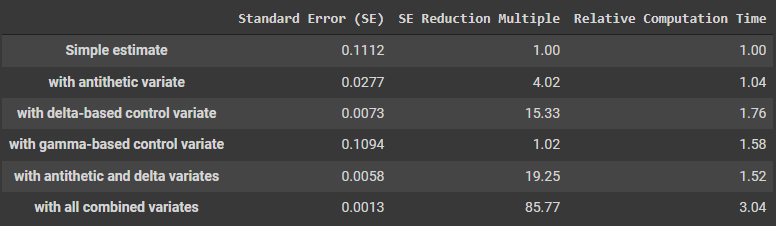